# Endogenous Grid Method

In the previous two notebooks, we discussed value function iteration and time-iteration. Today, I will be introducing you to the fastest method of solving models that we know of - the endogenous grid method (EGM).

Recall that so far, the procedure has been to **exogenously** create a grid of the state-space and to then solve for the optimal policy at each point in that grid - be it via maximization (VFI) or root-finding (time-iteration), which is a computationally expensive step. The EGM inverts this by doing the following: Instead of creating a grid on $k$, let's create a grid on $k^\prime$ and then try to back out what $k$ must have been in the first place to induce that exogenous choice of $k^\prime$!

Here's the EGM applied to 
$$
u_c(f(k) - k^\prime) = \beta f_k(k^\prime)u_c(f(k^\prime) - \overbrace{g(k^\prime)}^{k^{\prime\prime}})
$$
where it is understood that $g(k)$ is the policy function for next period's capital. I.e. in equilibrium, $k^\prime = g(k), k^{\prime\prime} = g(k^\prime)$, and so on.
1. Create a grid on $k^\prime$.
2. Create an initial guess for the policy function: $\tilde{g}_0(k)$. (The subscript corresponds to the iteration number). I like to make my initial guess correspond to the solution of the terminal period of the finite-horizon version of the problem. I.e. $\tilde{g}_0(k) = 0$ since there's no point in saving if there is no tomorrow. (What would the guess be if the policy function was defined in terms of consumption instead of next period's capital?)
3. We can now construct the right hand side of the Euler in closed-form for each point in our grid of $k^\prime$! I.e. for each $k^\prime_i$, compute:
$$
RHS(k^\prime_i) = \beta f_k(k^\prime_i)u_c(f(k^\prime_i) - \overbrace{\tilde{g}_0(k^\prime_i)}^{0})
$$
4. Apply the inverse of the marginal utility function on the RHS of the Euler equation for each $k^\prime_i$:
$$
f(k_i) - k^\prime_i = u_c^{-1}\left[RHS(k^\prime_i) \right]
$$
5. Use the resource constraint and invert the production function to back out $k_i$:
$$
f(k_i) = u_c^{-1}\left[RHS(k^\prime_i) \right] + k^\prime_i
$$
$$
k_i = f^{-1}\left[u_c^{-1}\left[RHS(k^\prime_i) \right] + k^\prime_i \right]
$$
When applied over the entire grid of $k^\prime$, notice that we have now **endogenously** generated a corresponding grid of $k$, i.e. we solved for what capital must have been to induce that exogenous choice in $k^\prime$!

6. We now have a mapping between $k$ and $k^\prime$!, which we can use to update our guess of the policy function for next period's capital. Note however that our endogenously grid of $k$ is most likely not the same as our exogenously grid of $k^\prime$. To evaluate whether we are close to the true policy function, compare our updated guess against the previous guess by evaluating it on the same points, which requires interpolating between $k$ and $k^\prime$. Denote the interpolate function as $\tilde{g}_1(k)$.

7. If $||\tilde{g}_1(k) - \tilde{g}_0(k)|| < \varepsilon$, stop. If not, start again from Step 2 with $\tilde{g}_1(k)$ until convergence.

Note the complete lack of any root-finding whatsoever throughout the entire process. Here's the Julia code to implement these steps:

In [2]:
using Interpolations, LinearAlgebra
using BenchmarkTools

#Economic parameters
const α = 0.4;
const β = 0.96;
const σ = 2.0;

#Creating the grid for k′
const nk′ = 1_001;
const k′min = 1e-3;
const k′max = 100.0;
const k′grid = range(k′min, k′max, length=nk′)

#Numerical parameters
const max_iter = 500;
const tol = 1e-8;

u(c) = log(c)
u_c(c) = 1/c
u_cinv(c) = 1/c

f(k) = k^α             #production function
f_k(k) = α*k^(α-1)      #first derivative of production function
f_inv(k) = k^(1/α)     #inverse of the production function

function solve_model_egm()
    kguess_V = zeros(nk′) #Initial guess that no new capital gets issued...terminal policy of a finite horizon problem

    iiter = 0

    @time while iiter < max_iter
        iiter +=1

        RHS_V = β*f_k.(k′grid).*u_c.(f.(k′grid) .- kguess_V)   #constructing the RHS of the consumption-Euler equation

        c̃_V = u_cinv.(RHS_V)

        kendog_V = f_inv.(c̃_V .+ k′grid) #Retrieving the k that would've made the k' optimal

        polk′_F = LinearInterpolation(kendog_V, k′grid) #Interpolating between k and kprime

        knew_V = polk′_F.(k′grid) #Evaluating the new pol func on the same points as the previous guess

        error = norm(knew_V - kguess_V, Inf)

        println("Iteration $iiter, Error: $error")

        kguess_V = copy(knew_V)

        if error < tol
            println("Converged after $iiter iterations")
            break
        end
    end

    return kguess_V
end 

pol_V = solve_model_egm();

Iteration 1, Error: 1.7495625037689053
Iteration 2, Error: 0.434265586663507
Iteration 3, Error: 0.14599860501150896
Iteration 4, Error: 0.04656886813184302
Iteration 5, Error: 0.022897854166458398
Iteration 6, Error: 0.007662704191095937
Iteration 7, Error: 0.0033866051642219563
Iteration 8, Error: 0.0015983376662076498
Iteration 9, Error: 0.0008148951500821511
Iteration 10, Error: 0.0004370406997000753
Iteration 11, Error: 0.00019619816172000704
Iteration 12, Error: 6.537098340730907e-5
Iteration 13, Error: 1.9542136257877374e-5
Iteration 14, Error: 5.547408701289669e-6
Iteration 15, Error: 1.5315759525069694e-6
Iteration 16, Error: 4.1618928348086115e-7
Iteration 17, Error: 1.1203768135459313e-7
Iteration 18, Error: 2.998989212521508e-8
Iteration 19, Error: 7.999833684380064e-9
Converged after 19 iterations
  0.001899 seconds (1.12 k allocations: 1.227 MiB)


Solving the model only took about 2 miliseconds - that's over 200 times faster than VFI and over 37 times faster than PFI! Additionally, note that there was no parallelization at all!

The EGM is a prime example of the benefits of exploiting whatever mathematical structure your problem possesses to the fullest extent. Model specific short-cuts can often result in much faster speed-ups than any supercomputer. We can also see that this blazing-fast speed did not come at any cost to accuracy, as it is virtually indistinguishable from the analytical policy function:

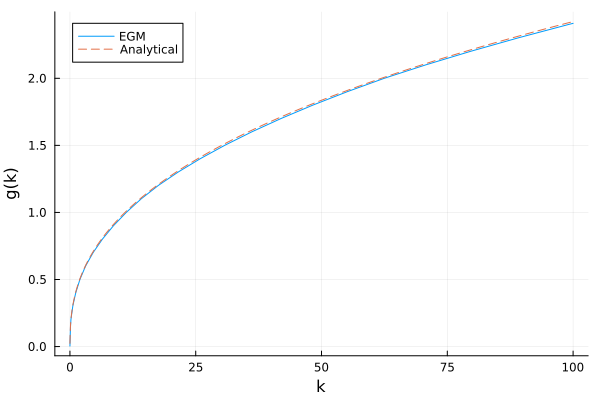

In [4]:
using Plots

plot(k′grid, pol_V,
    xlabel = "k", ylabel = "g(k)",
    label = "EGM")

pol_analyticalF(k) = α*β*f(k)

plot!(k′grid, pol_analyticalF.(k′grid),
    label = "Analytical",
    linestyle = :dash)

In [7]:
pol_F = LinearInterpolation(k′grid, pol_V)

function compute_euler_residual(k::Float64)
    k′ = pol_F(k)
    c = f(k) - k′
    LHS = u_c(c)
    k′′ = pol_F(k′)
    c′ = f(k′) - k′′
    RHS = β * f_k(k′) * u_c(c′)
    return log10(abs(LHS/RHS - 1))
end

kfine_V = range(k′min, k′max, length=5_001)
errors_V = compute_euler_residual.(kfine_V)

using Statistics

mean(errors_V)

-3.228429389927856

## Conditions

There are two main additional assumptions (ontop of the Euler equation holding globally across the state-space like in time-iteration) that you need for the EGM that I just presented to be applicable:
1. Invertibility of the marginal utility function. Fortunately, the utility functions that macroeconomists use typically fulfill this criteria. 
2. Monotonicity of the policy function(s) - If your policy function(s) are non-monotonic, then the interpolation step will fail. This can be problematic in high-dimensional worlds where policy functions are often non-monotonic! Fortunately, there is a literature dedicated to finding clever ways to circumvent this requirement, albeit at the cost of some of the speed gains EGM would deliver in a nice environment.

The eagle-eyed among you also may have noticed that I may have made things deceptively simple by assuming full depreciation, and that by breaking this assumption, completely avoiding root-finding to endogenously retrieve $k$ becomes impossible in Step 5. Indeed, one of the main speed-gains from EGM comes from the fact that the FOC is linear in $k$ but not $k^\prime$, but this is no longer true if $\delta < 1$.

Firstly, you will still see some speed-gains since the function you need to find a root for is now is alot simpler:
$$
f(k_i) + (1-\delta)k_i = u_c^{-1}\left[RHS(k^\prime_i) \right] + k^\prime_i
$$
Secondly, with a clever reformulation of the problem, we can get away with only using costly root-finding only **once** throughout the entire solution method, rather than once in **each iteration**.